https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
Placed dataset under /home/jeff/Desktop/WD18/grid_kaggle/[train.csv test.csv]

Great example on how to tune the parameters of the model through a sort of grid search method.

What is the best CNN architecture for MNIST?

There are so many choices for CNN architecture. How do we choose the best one? First we must define what best means. The best may be the simplest, or it may be the most efficient at producing accuracy while minimizing computational complexity. In this kernel, we will run experiments to find the most accurate and efficient CNN architecture for classifying MNIST handwritten digits.

The best known MNIST classifier found on the internet achieves 99.8% accuracy!! That's amazing. The best Kaggle kernel MNIST classifier achieves 99.75% [posted here][1]. This kernel demostrates the experiments used to determine that kernel's CNN architecture. [1]:https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist


Basic CNN structure

A typical CNN design begins with feature extraction and finishes with classification. Feature extraction is performed by alternating convolution layers with subsambling layers. Classification is performed with dense layers followed by a final softmax layer. For image classification, this architecture performs better than an entirely fully connected feed forward neural network. extract
![image.png](attachment:extract.png)
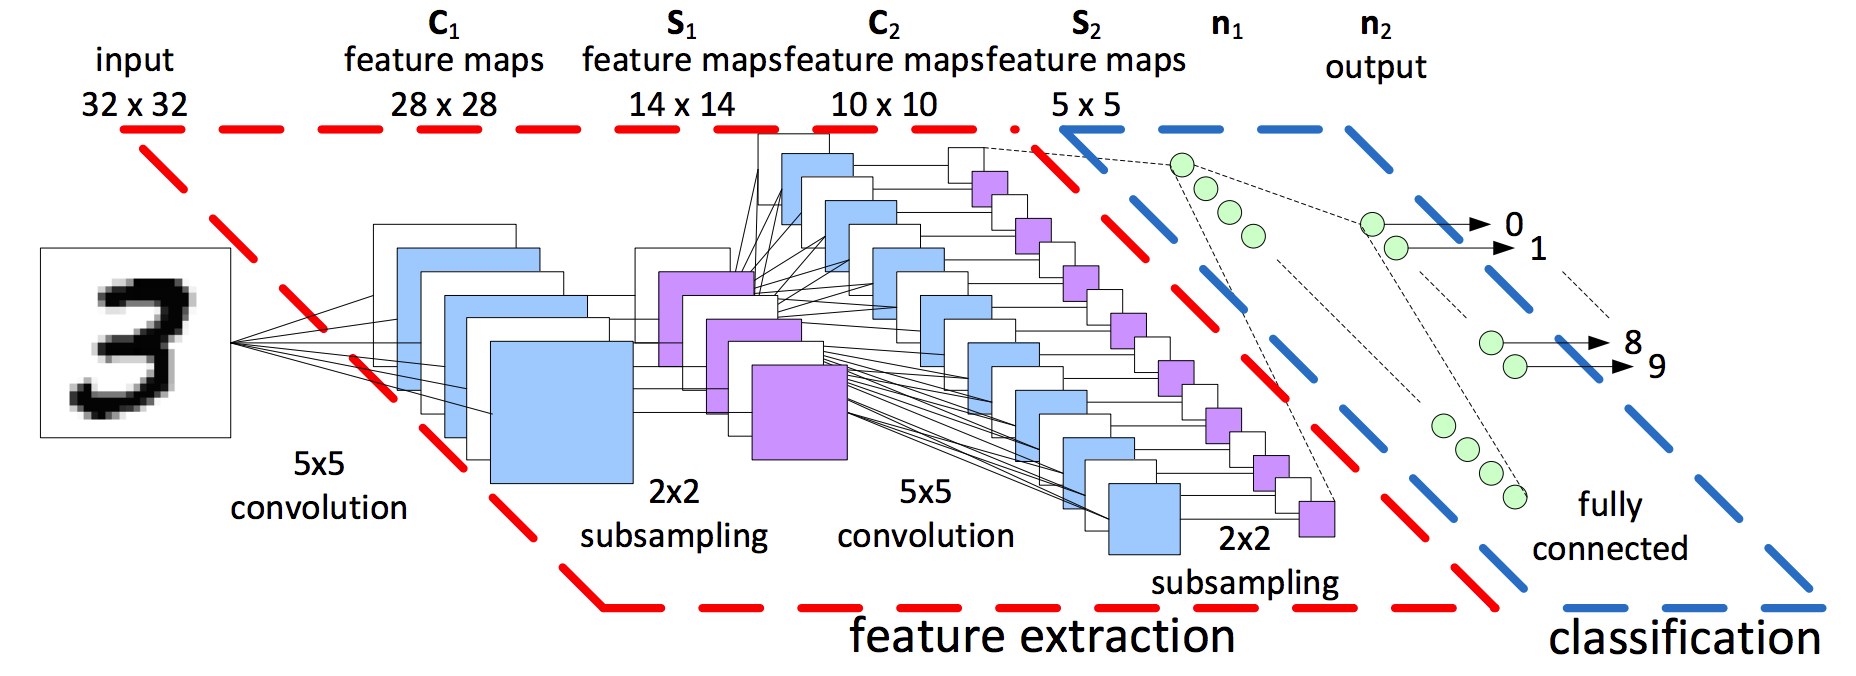


![extract.png](/home/jeff/Pictures/extract.png)

Notation in this Kaggle kernel

Throughout this kernel, we'll use the following notation:

    24C5 means a convolution layer with 24 feature maps using a 5x5 filter and stride 1
    24C5S2 means a convolution layer with 24 feature maps using a 5x5 filter and stride 2
    P2 means max pooling using 2x2 filter and stride 2
    256 means fully connected dense layer with 256 units

Keras API

In Keras, to add a convolutional layer, you write model.add(Conv2D(filters=48,kernel_size=5,strides=1,padding='same',activation='relu'))
What do all these terms mean?

    filters is the number of desired feature maps.

    kernel_size is the size of the convolution kernel. A single number 5 means a 5x5 convolution.

    strides the new layer maps will have a size equal to the previous layer maps divided by strides. Leaving this blank results in strides=1.

    padding is either 'same' or 'valid'. Leaving this blank results in padding='valid'. If padding is 'valid' then the size of the new layer maps is reduced by kernel_size-1. For example, if you perform a 5x5 convolution on a 28x28 image (map) with padding='valid', then the next layer has maps of size 24x24. If padding is 'same', then the size isn't reduced.

    activation is applied during forward propagation. Leaving this blank results in no activation.

    You can always view all of the layer sizes in your convolutional network by issuing the command model.summary()



In [1]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# LOAD THE DATA
train = pd.read_csv("/home/jeff/Desktop/WD18/grid_kaggle/train.csv")
test = pd.read_csv("/home/jeff/Desktop/WD18/grid_kaggle/test.csv")

# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

1. How many convolution-subsambling pairs?

First question, how many pairs of convolution-subsampling should we use? For example, our network could have 1, 2, or 3:

    784 - [24C5-P2] - 256 - 10
    784 - [24C5-P2] - [48C5-P2] - 256 - 10
    784 - [24C5-P2] - [48C5-P2] - [64C5-P2] - 256 - 10

It's typical to increase the number of feature maps for each subsequent pair as shown here.

Experiment 1

Let's see whether one, two, or three pairs is best. We are not doing four pairs since the image will be reduced too small before then. The input image is 28x28. After one pair, it's 14x14. After two, it's 7x7. After three it's 4x4 (or 3x3 if we don't use padding='same'). It doesn't make sense to do a fourth convolution.


In [43]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 3
model = [0] *nets

for j in range(3):
    model[j] = Sequential()
    model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
            input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    if j>0:
        model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D())
    if j>1:
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [10]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)

In [44]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+epochs))

# TRAIN NETWORKS
history = [0] * nets
names = ["(C-P)x1","(C-P)x2","(C-P)x3"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))



CNN (C-P)x1: Epochs=20, Train accuracy=0.99964, Validation accuracy=0.98534
CNN (C-P)x2: Epochs=20, Train accuracy=0.99971, Validation accuracy=0.98842
CNN (C-P)x3: Epochs=20, Train accuracy=0.99975, Validation accuracy=0.98813


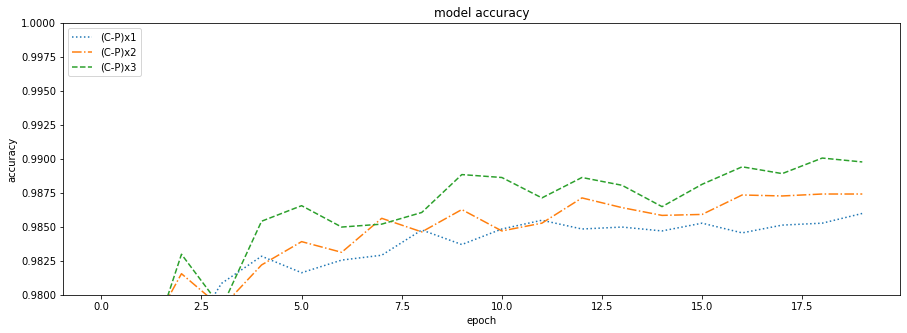

In [12]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

2. How many feature maps?

In the previous experiement, we decided that two pairs is sufficient. How many feature maps should we include? For example, we could do

    784 - [8C5-P2] - [16C5-P2] - 256 - 10
    784 - [16C5-P2] - [32C5-P2] - 256 - 10
    784 - [24C5-P2] - [48C5-P2] - 256 - 10
    784 - [32C5-P2] - [64C5-P2] - 256 - 10
    784 - [48C5-P2] - [96C5-P2] - 256 - 10
    784 - [64C5-P2] - [128C5-P2] - 256 - 10

Experiment 2

In [17]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 6
model = [0] *nets
for j in range(6):
    model[j] = Sequential()
    model[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(j*16+16,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])

In [18]:


# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))



CNN 8 maps: Epochs=20, Train accuracy=0.99407, Validation accuracy=0.98384
CNN 16 maps: Epochs=20, Train accuracy=0.99893, Validation accuracy=0.98777
CNN 24 maps: Epochs=20, Train accuracy=0.99939, Validation accuracy=0.98899
CNN 32 maps: Epochs=20, Train accuracy=0.99968, Validation accuracy=0.98870
CNN 48 maps: Epochs=20, Train accuracy=0.99939, Validation accuracy=0.98906
CNN 64 maps: Epochs=20, Train accuracy=0.99993, Validation accuracy=0.98906


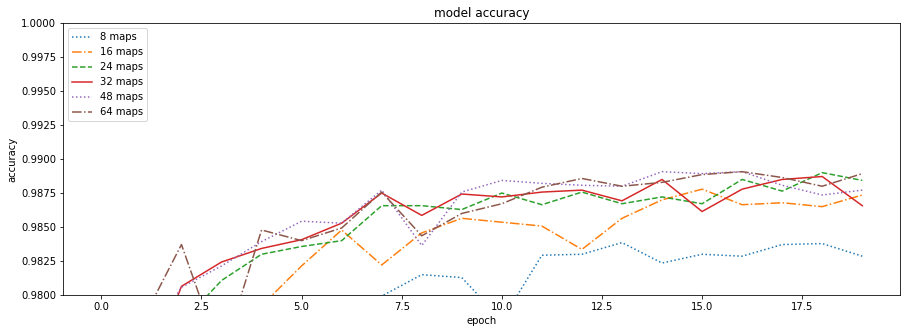

In [19]:


# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()



3. How large a dense layer?

In our previous experiment, we decided on 32 and 64 maps in our convolutional layers. How many dense units should we use? For example we could use

    784 - [32C5-P2] - [64C5-P2] - 0 - 10
    784 - [32C5-P2] - [64C5-P2] - 32 - 10
    784 - [32C5-P2] - [64C5-P2] - 64 - 10
    784 - [32C5-P2] - [64C5-P2] - 128 -10
    784 - [32C5-P2] - [64C5-P2] - 256 - 10
    784 - [32C5-P2] - [64C5-P2] - 512 -10
    784 - [32C5-P2] - [64C5-P2] - 1024 - 10
    784 - [32C5-P2] - [64C5-P2] - 2048 - 10

Experiment 3

In [20]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [21]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["0N","32N","64N","128N","256N","512N","1024N","2048N"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 0N: Epochs=20, Train accuracy=0.99657, Validation accuracy=0.98734
CNN 32N: Epochs=20, Train accuracy=0.99804, Validation accuracy=0.98692
CNN 64N: Epochs=20, Train accuracy=0.99839, Validation accuracy=0.98806
CNN 128N: Epochs=20, Train accuracy=0.99932, Validation accuracy=0.98920
CNN 256N: Epochs=20, Train accuracy=0.99954, Validation accuracy=0.99078
CNN 512N: Epochs=20, Train accuracy=0.99986, Validation accuracy=0.99135
CNN 1024N: Epochs=20, Train accuracy=0.99996, Validation accuracy=0.99128
CNN 2048N: Epochs=20, Train accuracy=0.99986, Validation accuracy=0.99106


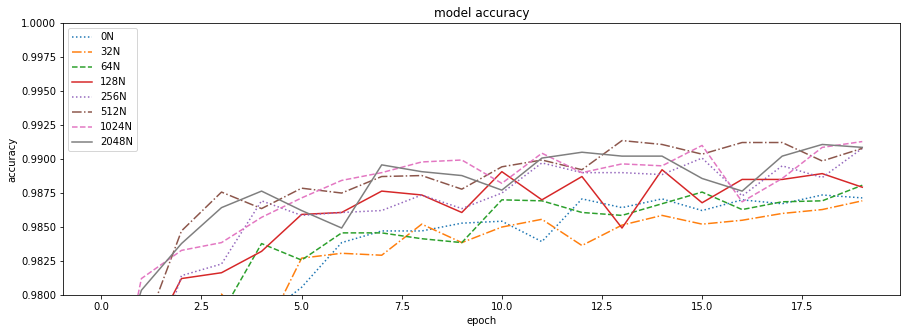

In [22]:


# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()



4. How much dropout?

Dropout will prevent our network from overfitting thus helping our network generalize better. How much dropout should we add after each layer?

    0%, 10%, 20%, 30%, 40%, 50%, 60%, or 70%

Experiment 4

In [23]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [24]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
epochs = 30
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN D=0: Epochs=30, Train accuracy=0.99961, Validation accuracy=0.98827
CNN D=0.1: Epochs=30, Train accuracy=0.99582, Validation accuracy=0.98949
CNN D=0.2: Epochs=30, Train accuracy=0.99193, Validation accuracy=0.99071
CNN D=0.3: Epochs=30, Train accuracy=0.98901, Validation accuracy=0.99028
CNN D=0.4: Epochs=30, Train accuracy=0.98319, Validation accuracy=0.98985
CNN D=0.5: Epochs=30, Train accuracy=0.97494, Validation accuracy=0.98699
CNN D=0.6: Epochs=30, Train accuracy=0.96288, Validation accuracy=0.98484
CNN D=0.7: Epochs=30, Train accuracy=0.93710, Validation accuracy=0.97841


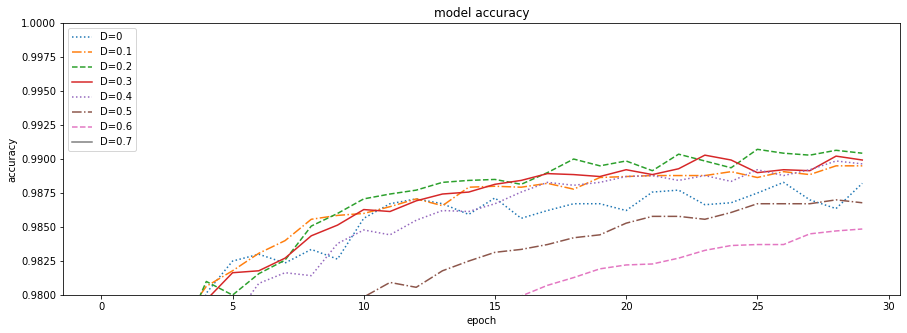

In [25]:


# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()



5. Advanced features

Instead of using one convolution layer of size 5x5, you can mimic 5x5 by using two consecutive 3x3 layers and it will be more nonlinear. Instead of using a max pooling layer, you can subsample by using a convolution layer with strides=2 and it will be learnable. Lastly, does batch normalization help? And does data augmentation help? Let's test all four of these

    replace '32C5' with '32C3-32C3'
    replace 'P2' with '32C5S2'
    add batch normalization
    add data augmentation



In [26]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 5
model = [0] *nets

j=0
model[j] = Sequential()
model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.4))
model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.4))
model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.4))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

j=1
model[j] = Sequential()
model[j].add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.4))
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.4))
model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.4))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

j=2
model[j] = Sequential()
model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(Dropout(0.4))
model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(Dropout(0.4))
model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.4))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

j=3
model[j] = Sequential()
model[j].add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))
model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.4))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])


In [27]:
j=4
model[j] = Sequential()

model[j].add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))

model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))
model[j].add(Dense(10, activation='softmax'))

model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])


In [28]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.2)
# TRAIN NETWORKS 1,2,3,4
history = [0] * nets
names = ["basic","32C3-32C3","32C5S2","both+BN","both+BN+DA"]
epochs = 35
for j in range(nets-1):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=64, epochs = epochs,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))
    
# CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
# TRAIN NETWORK 5
j = nets-1
history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64), 
    epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,
    validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN basic: Epochs=35, Train accuracy=0.98440, Validation accuracy=0.98917
CNN 32C3-32C3: Epochs=35, Train accuracy=0.98771, Validation accuracy=0.99226
CNN 32C5S2: Epochs=35, Train accuracy=0.99295, Validation accuracy=0.99167
CNN both+BN: Epochs=35, Train accuracy=0.99649, Validation accuracy=0.99345
Instructions for updating:
Please use Model.fit, which supports generators.
CNN both+BN+DA: Epochs=35, Train accuracy=0.98946, Validation accuracy=0.99464


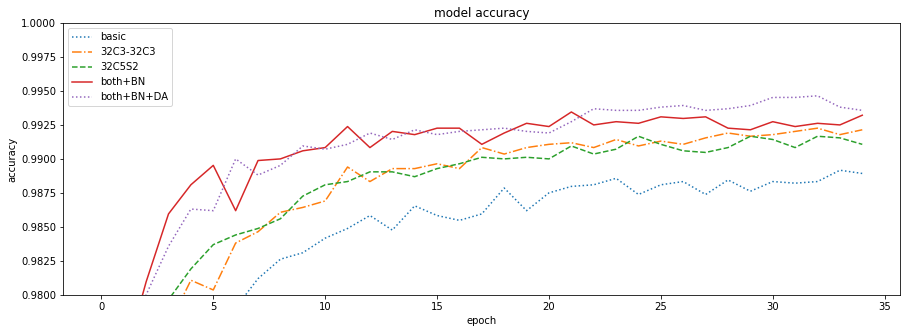

In [29]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

Conclusion

Training convolutional neural networks is a random process. This makes experiments difficult because each time you run the same experiment, you get different results. Therefore, you must run your experiments dozens of times and take an average. This kernel was run dozens of times and it seems that the best CNN architecture for classifying MNIST handwritten digits is 784 - [32C5-P2] - [64C5-P2] - 128 - 10 with 40% dropout. Afterward, more experiments show that replacing '32C5' with '32C3-32C3' improves accuracy. And replacing 'P2' with '32C5S2' improves accuracy. And adding batch normalizaiton and data augmentation improve the CNN. The best CNN found from the experiments here becomes

    784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10
    with 40% dropout, batch normalization, and data augmentation added

You can see an ensemble of these CNNs achieve 99.75% accuracy by clicking here. Thanks for reading my kernel. If anyone has ideas to improve CNN architecture for classifying MNIST handwritten digits, please comment. Also I encourage people to fork this kernel, change the code, and test new CNN architectures of your design.
